# Pybites Community Branch Activity

First of all, I start off with importing everything that I will need.

In [1]:
import json
from collections import Counter

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dateutil.parser import parse
from matplotlib import rc
from matplotlib.pyplot import figure

## Importing the Data

Next, I import the json data from the files that I was able to collect from GitHub without using authentication, which wasn't much...

In [2]:
# load data
page = "data/events{}.json"
events = []
for p in range(1, 4):
    with open(page.format(p)) as file:
        events.extend(json.loads(file.read()))
len(events)

300

## Parsing the Data

I created this helper funtion in order to keep from repeating myself in the parsing section.

In [3]:
# helper function
def parse_data(line):
    if '[' in line:
        data = line.split(': [')[1].replace(']', '').strip()
    else:
        data = line.split(': ')[1].strip()
    return data

I next move unto parsing the data and saving them into seperate lists.

In [4]:
# parse data
created = []
devs = []
diff_levels = []
time_spent = []

for event in events:
    if event['type'] == 'PullRequestEvent':
        # developer username
        dev = event['actor']['login']
        # ignore pybites ;)
        if dev != 'pybites':
            # store developer username
            devs.append(dev)
            # store the date
            created.append(event['created_at'].split('T')[0])
            # parse comment from user for data
            comment = event['payload']['pull_request']['body']
            for line in comment.split('\n'):
                # get difficulty level and time spent
                if 'Difficulty level (1-10):' in line:
                    diff = parse_data(line)
                elif 'Estimated time spent (hours):' in line:
                    spent = parse_data(line)
            # pandas DataFrames require that all columns are the same length
            # so if we have a missing value, enter None in its place
            if diff:
                diff_levels.append(int(diff))
            else:
                diff_levels.append(None)
            if spent:
                time_spent.append(int(spent))
            else:
                time_spent.append(None)

## DataFrame

Now that I have the lists, I create a DataFrame with them.

In [5]:
# create the DataFrame
df = pd.DataFrame({
    'Developers': devs, 
    'Difficulty_Levels': diff_levels, 
    'Time_Spent': time_spent,
    'Date': created,
})
df

,Developers,Difficulty_Levels,Time_Spent,Date
0,mridubhatnagar,NaN,NaN,2018-10-12
1,vipinreyo,2.0,3.0,2018-10-12
2,clamytoe,2.0,2.0,2018-10-11
3,habereet,1.0,1.0,2018-10-10
4,mridubhatnagar,NaN,NaN,2018-10-09
5,htv2012,NaN,NaN,2018-10-09
6,mridubhatnagar,NaN,NaN,2018-10-08
7,bryankimani,NaN,NaN,2018-10-08
8,pgmilenkov,4.0,2.0,2018-10-08
9,pgmilenkov,6.0,2.0,2018-10-08


## Data Exploration

Here, we can start exploring the data.

In [6]:
# lets examine our df
df.describe()

,Difficulty_Levels,Time_Spent
count,57.000000,57.000000
mean,3.666667,2.561404
std,1.825742,1.945852
min,1.000000,1.000000
25%,2.000000,1.000000
50%,4.000000,2.000000
75%,5.000000,3.000000
max,8.000000,8.000000


Exploration starts, just wanted to get a feel for things here.

In [7]:
# just exploring the data
print(f'Developers: {len(df["Developers"])}')
print(f'Average Difficulty: {df["Difficulty_Levels"].median()}')
print(f'Time Spent: {df["Time_Spent"].sum()}')

Developers: 71
Average Difficulty: 4.0
Time Spent: 146.0


The following Counters are just me exploring the data even further.

In [8]:
# developer counter
developers = Counter(df['Developers']).most_common(6)
developers

[('sorian', 16),
 ('clamytoe', 11),
 ('vipinreyo', 9),
 ('pgmilenkov', 6),
 ('demarcoz', 6),
 ('mridubhatnagar', 4)]

In [9]:
# difficulty counter
bite_difficulty = Counter(df['Difficulty_Levels'].dropna()).most_common()
bite_difficulty

[(2.0, 12), (4.0, 10), (5.0, 10), (6.0, 8), (3.0, 8), (1.0, 7), (8.0, 2)]

In [10]:
# duration counter
bite_duration = Counter(df['Time_Spent'].dropna()).most_common()
bite_duration

[(1.0, 21), (2.0, 15), (3.0, 9), (4.0, 6), (8.0, 4), (6.0, 2)]

In [11]:
# date counter
created_at = sorted(Counter(df['Date'].dropna()).most_common())
created_at

[('2018-10-02', 12),
 ('2018-10-03', 6),
 ('2018-10-04', 8),
 ('2018-10-05', 16),
 ('2018-10-07', 14),
 ('2018-10-08', 8),
 ('2018-10-09', 3),
 ('2018-10-10', 1),
 ('2018-10-11', 1),
 ('2018-10-12', 2)]

## Number of Pull Request per Day

Pretty amazing that [Pybites Blog Challenges](https://codechalleng.es/challenges/) had over **300** distinct github interactions in just **10 days**!!!

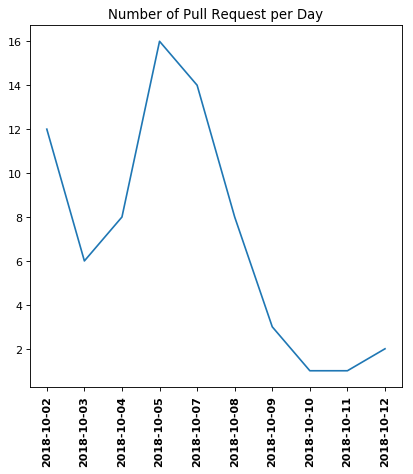

In [12]:
# resize graph
figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')

# gather data into a custom DataFrame
dates = [day[0] for day in created_at]
prs = [pr[1] for pr in created_at]
df_prs = pd.DataFrame({'xvalues': dates, 'yvalues': prs})
 
# plot
plt.plot('xvalues', 'yvalues', data=df_prs)

# labels
plt.xticks(rotation='vertical', fontweight='bold')

# title
plt.title('Number of Pull Request per Day')

# show the graphic
plt.show()

## Top Blog Challenge Ninjas

Although there are many more contributors, I had to limit the count so that the data would be easier to visualize.

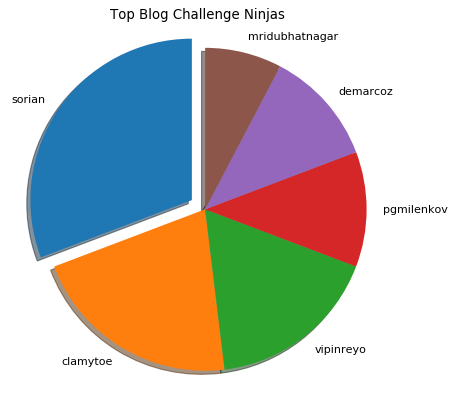

In [13]:
# resize graph
figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')

# create labels
labels = [dev[0] for dev in developers]

# get a count of the pull requests
prs = [dev[1] for dev in developers]

# pull out top ninja slice
explode = [0] * len(developers)
explode[0] = 0.1

# create the pie chart
plt.pie(prs, explode=explode, labels=labels, shadow=True, startangle=90)

# add title and center
plt.axis('equal')
plt.title('Top Blog Challenge Ninjas')

# show the graphic
plt.show()

## Time Spent/Difficulty Level per Pull Request

Finally I wanted to explore what the relation between time spent per PR vs how difficult the develop found the challenge to be.

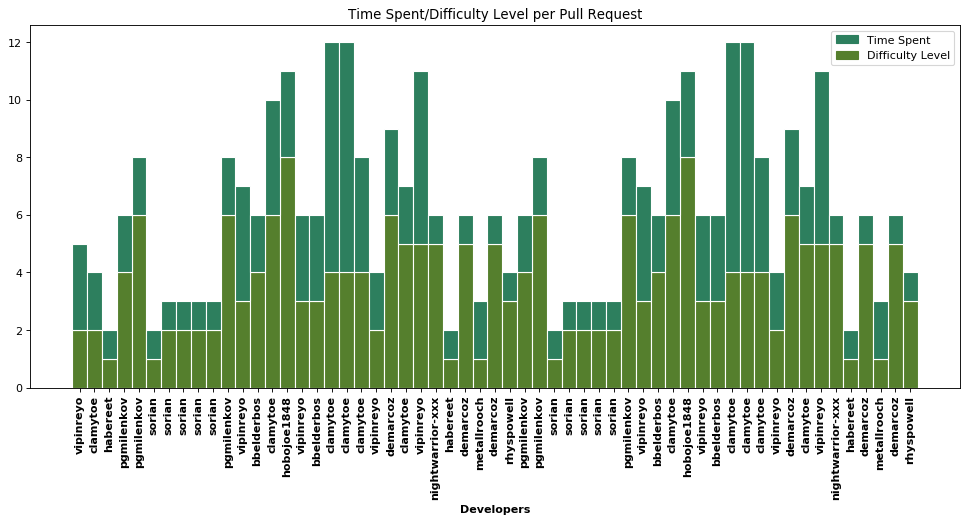

In [14]:
# resize graph
figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')

# drop null values
df_clean = df.dropna()

# add legend
diff = mpatches.Patch(color='#557f2d', label='Difficulty Level')
time = mpatches.Patch(color='#2d7f5e', label='Time Spent')
plt.legend(handles=[time, diff])

# y-axis in bold
rc('font', weight='bold')

# values of each group
bars1 = df_clean['Difficulty_Levels']
bars2 = df_clean['Time_Spent']

# heights of bars1 + bars2
bars = df_clean['Difficulty_Levels'] + df_clean['Time_Spent']

# position of the bars on the x-axis
r = range(len(df_clean))

# names of group and bar width
names = df_clean['Developers']
barWidth = 1

# create green bars (bottom)
plt.bar(r, bars1, color='#557f2d', edgecolor='white', width=barWidth)
# create green bars (top), on top of the firs ones
plt.bar(r, bars2, bottom=bars1, color='#2d7f5e', edgecolor='white', width=barWidth)

# custom X axis
plt.xticks(r, names, rotation='vertical', fontweight='bold')
plt.xlabel("Developers", fontweight='bold')

# title
plt.title('Time Spent/Difficulty Level per Pull Request')

# show graphic
plt.show()